# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [3]:
# Install the required libraries
!pip install prophet

In [4]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [43]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-43-217fb1a948ac>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [44]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


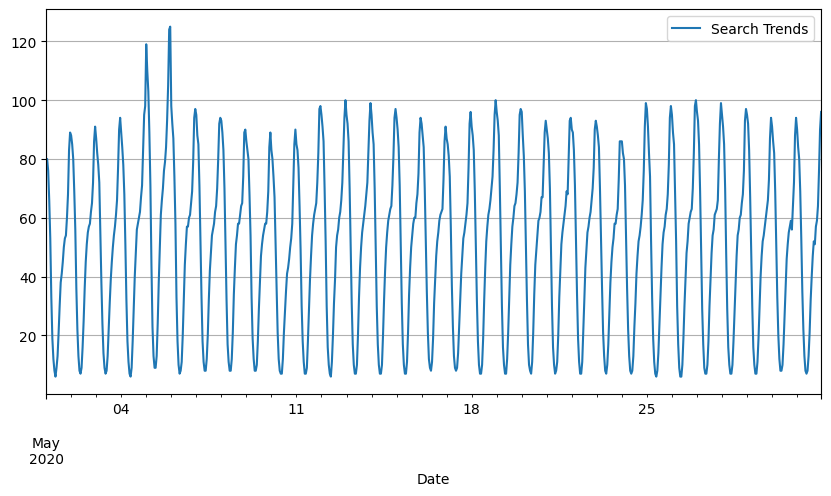

In [45]:
# Slice the DataFrame to just the month of May 2020
df_may_2020 = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Plot to visualize the data for May 2020
ax = df_may_2020['Search Trends'].plot(
    figsize=(10, 5),
    xlabel='Date',
    ylabel='',
    legend=True,
    grid=True
)
plt.xticks()
plt.legend(['Search Trends'])
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [46]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = df_may_2020['Search Trends'].sum()

# Create a Series to display the result in the desired format
traffic_may_2020_series = pd.Series({'Search Trends': traffic_may_2020})

# Display the Series with the result
traffic_may_2020_series


Search Trends    38181
dtype: int64

In [47]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends'].sum().median()

# View the median_monthly_traffic value
# Create a Series to display the result in the desired format
median_monthly_traffic_series = pd.Series({'Search Trends': median_monthly_traffic})

# Display the Series with the result
median_monthly_traffic_series


Search Trends    35172.5
dtype: float64

In [48]:
# Compare the search traffic for the month of May 2020 to the overall monthly median value
traffic_comparison = traffic_may_2020 / median_monthly_traffic

# Create a Series to display the result in the desired format
traffic_comparison_series = pd.Series({'Search Trends': traffic_comparison})

# Display the Series with the result
traffic_comparison_series


Search Trends    1.085536
dtype: float64

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the Google search traffic increased during the month that MercadoLibre released its financial results.


In [49]:
print("Total Search Traffic for May 2020:", traffic_may_2020)
print("Overall Monthly Median Search Traffic:", median_monthly_traffic)
print("Comparison Ratio:", traffic_comparison)

# Write the conclusion based on the comparison ratio
if traffic_comparison > 1:
    print("Yes, the Google search traffic increased during the month that MercadoLibre released its financial results.")
else:
    print("No, the Google search traffic did not increase during the month that MercadoLibre released its financial results.")


Total Search Traffic for May 2020: 38181
Overall Monthly Median Search Traffic: 35172.5
Comparison Ratio: 1.0855355746677091
Yes, the Google search traffic increased during the month that MercadoLibre released its financial results.


## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

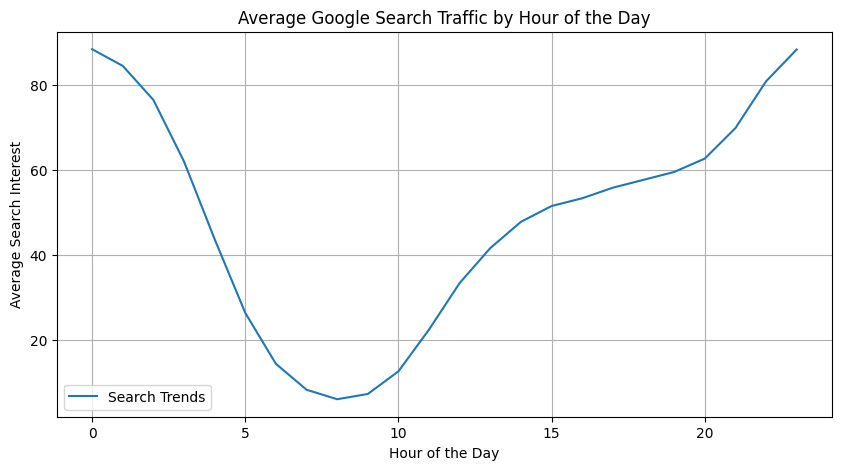

In [50]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
# Group the hourly search data to plot the average traffic by the hour of the day
average_traffic_by_hour = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()

# Plot the average traffic by the hour of the day using pandas plotting
ax = average_traffic_by_hour.plot(
    figsize=(10, 5),
    title='Average Google Search Traffic by Hour of the Day',
    ylabel='Average Search Interest',
    legend=True,
    grid=True
)
ax.set_xlabel('Hour of the Day')
plt.show()


#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

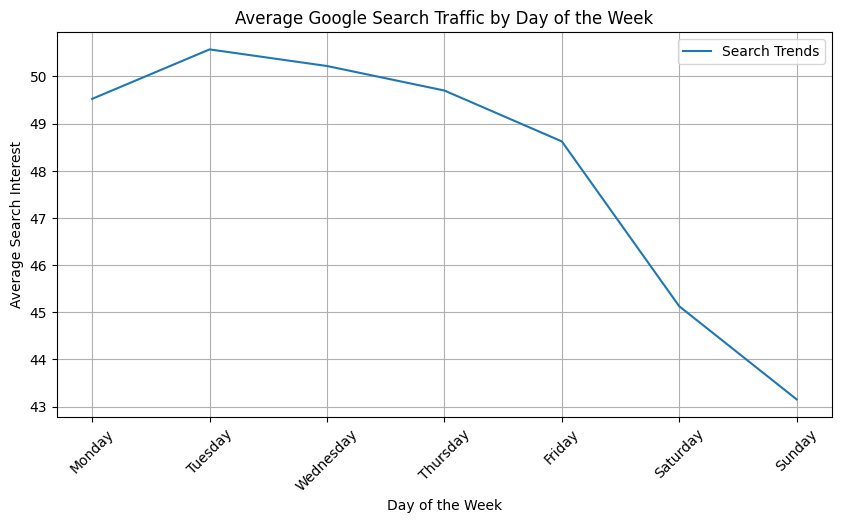

In [51]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
# Group the hourly search data to plot the average traffic by the day of the week
average_traffic_by_day_of_week = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()

# Plot the average traffic by the day of the week using pandas plotting
ax = average_traffic_by_day_of_week.plot(
    figsize=(10, 5),
    title='Average Google Search Traffic by Day of the Week',
    xlabel='Day of the Week',
    ylabel='Average Search Interest',
    legend=True,
    grid=True
)
ax.set_xticks(range(1, 8))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

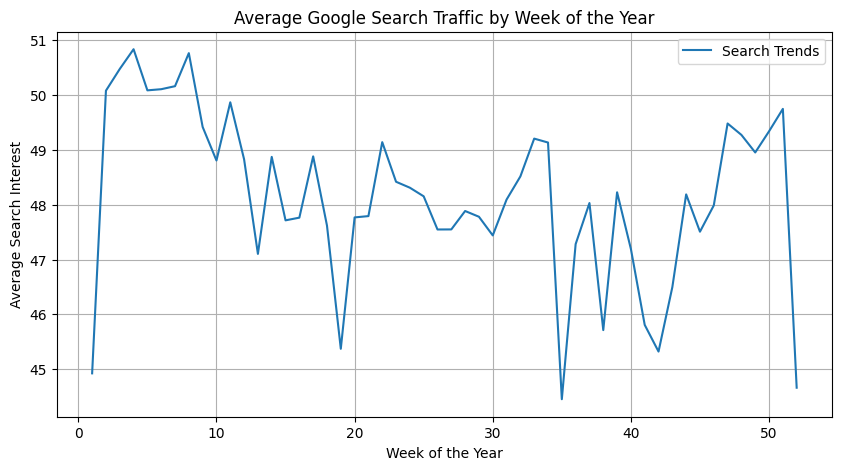

In [52]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
average_traffic_by_week_of_year = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()

# Plot the average traffic by the week of the year using pandas plotting
ax = average_traffic_by_week_of_year.plot(
    figsize=(10, 5),
    title='Average Google Search Traffic by Week of the Year',
    xlabel='Week of the Year',
    ylabel='Average Search Interest',
    legend=True,
    grid=True
)
plt.show()


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**
Yes, there are several time-based trends observable in the Google search traffic data:


**Hourly Trends:**

The data shows that Google search traffic trends upward daily after 10 AM, indicating increased activity as the day progresses.

**Daily Trends:**

Search traffic peaks on Monday, Tuesday, and Wednesday, suggesting higher interest or activity during the early part of the week.
There is a noticeable decline in search traffic starting on Thursday, with the lowest levels observed on Friday, Saturday, and Sunday. This pattern may reflect reduced activity or engagement towards the end of the week and over the weekend.

**Weekly Trends:**

An upward trend in Google search traffic is seen during the first 10 weeks of the year, with particularly steep increases during the 2nd and 3rd weeks.
A drop in traffic occurs from the 17th to the 19th week, followed by an uptick from the 20th to the 34th week.
There is a decline during the 35th week, and an alternating pattern of uptick and decline from the 36th to the 43rd weeks.
An upward trend is observed from the 44th to the 53rd weeks, which may coincide with increased activity towards the end of the year.
Finally, a steep decline is noted during the 54th week, possibly reflecting a post-holiday drop in activity.
These patterns highlight consistent fluctuations in search traffic that correspond to specific times of the day, days of the week, and weeks of the year, providing valuable insights for understanding user behavior and planning marketing strategies.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [53]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


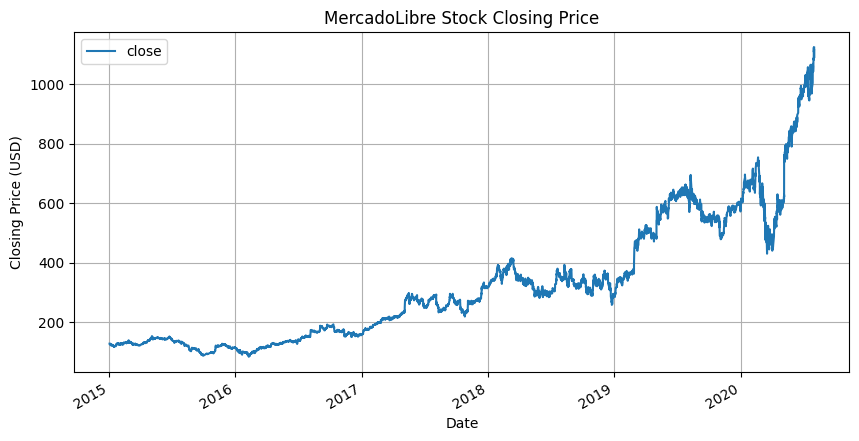

In [54]:
# Visualize the closing price of the df_mercado_stock DataFrame
ax = df_mercado_stock['close'].plot(
    figsize=(10, 5),
    title='MercadoLibre Stock Closing Price',
    xlabel='Date',
    ylabel='Closing Price (USD)',
    legend=True,
    grid=True
)
plt.show()


In [55]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna(how='any')

# View the first and last five rows of the DataFrame
display(df_combined.head())
display(df_combined.tail())


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [56]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_combined.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())


,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


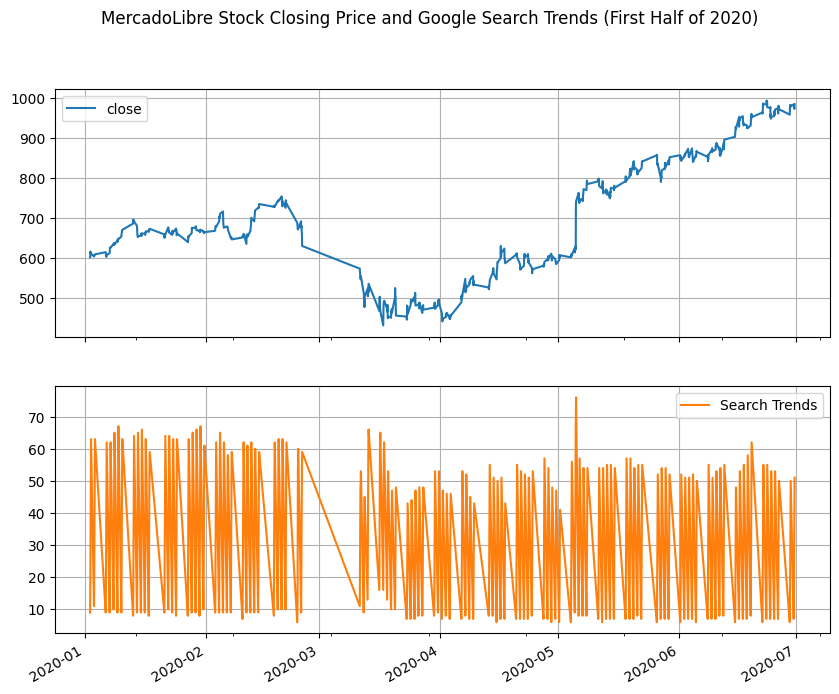

In [57]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
ax = first_half_2020[['close', 'Search Trends']].plot(
    figsize=(10, 8),
    subplots=True,
    title='MercadoLibre Stock Closing Price and Google Search Trends (First Half of 2020)',
    legend=True,
    grid=True
)
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**

1.) **Stock Closing Price:**

The stock price experienced a decline around March 2020, likely corresponding to the initial shock of the COVID-19 pandemic.
Following the initial decline, the stock price showed a steady upward trend, reflecting recovery and growth, possibly due to increased demand for e-commerce services.

2.) **Google Search Trends:**

The search interest for MercadoLibre showed a decline around the same period (March 2020), consistent with the initial market shock.
After the decline, search trends also increased, indicating growing interest or activity on the platform.

**Conclusion:**
Yes, both time series indicate a common trend that is consistent with the narrative of initial market shock followed by recovery and growth. The decline in March 2020 aligns with the global financial market disruption due to the pandemic. Subsequently, both the stock price and Google search interest show an upward trend, reflecting increased demand for e-commerce services and heightened interest in MercadoLibre as more consumers shifted to online shopping during the pandemic.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [58]:
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1).dropna(how='any')

first_half_2020 = df_combined.loc['2020-01-01':'2020-06-30']

# Create a new column in the first_half_2020 DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
first_half_2020['Lagged Search Trends'] = first_half_2020['Search Trends'].shift(1)

# View the first and last five rows of the updated DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())


<ipython-input-58-cb4db98243f6>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half_2020['Lagged Search Trends'] = first_half_2020['Search Trends'].shift(1)


,close,Search Trends,Lagged Search Trends
2020-01-02 09:00:00,601.085,9.0,NaN
2020-01-02 10:00:00,601.290,14.0,9.0
2020-01-02 11:00:00,615.410,25.0,14.0
2020-01-02 12:00:00,611.400,37.0,25.0
2020-01-02 13:00:00,611.830,50.0,37.0


,close,Search Trends,Lagged Search Trends
2020-06-30 11:00:00,976.17,17.0,11.0
2020-06-30 12:00:00,977.50,27.0,17.0
2020-06-30 13:00:00,973.23,37.0,27.0
2020-06-30 14:00:00,976.50,45.0,37.0
2020-06-30 15:00:00,984.93,51.0,45.0


In [59]:
# Create a new column in the first_half_2020 DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4-period rolling window
first_half_2020['Stock Volatility'] = first_half_2020['close'].pct_change().rolling(window=4).std()

# View the first and last five rows of the updated DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())


<ipython-input-59-8ce32469fa6e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_half_2020['Stock Volatility'] = first_half_2020['close'].pct_change().rolling(window=4).std()


,close,Search Trends,Lagged Search Trends,Stock Volatility
2020-01-02 09:00:00,601.085,9.0,NaN,NaN
2020-01-02 10:00:00,601.290,14.0,9.0,NaN
2020-01-02 11:00:00,615.410,25.0,14.0,NaN
2020-01-02 12:00:00,611.400,37.0,25.0,NaN
2020-01-02 13:00:00,611.830,50.0,37.0,0.013082


,close,Search Trends,Lagged Search Trends,Stock Volatility
2020-06-30 11:00:00,976.17,17.0,11.0,0.004288
2020-06-30 12:00:00,977.50,27.0,17.0,0.004086
2020-06-30 13:00:00,973.23,37.0,27.0,0.003014
2020-06-30 14:00:00,976.50,45.0,37.0,0.003557
2020-06-30 15:00:00,984.93,51.0,45.0,0.005372


In [60]:
# Check the range of the data in first_half_2020 DataFrame
print(first_half_2020.index.min())
print(first_half_2020.index.max())


2020-01-02 09:00:00
2020-06-30 15:00:00


In [61]:
# Recalculate Stock Volatility for the entire dataset
df_combined['Stock Volatility'] = df_combined['close'].pct_change().rolling(window=4).std()

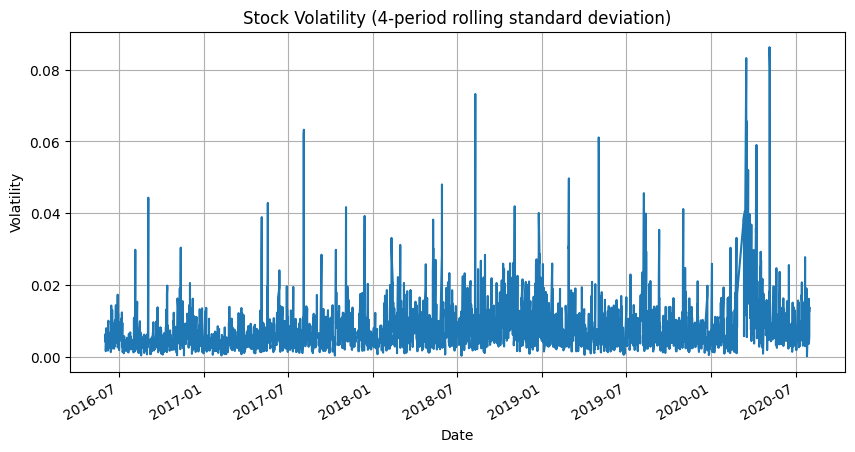

In [62]:
# Visualize the stock volatility
# Visualize the stock volatility for the full range
ax = df_combined['Stock Volatility'].plot(
    figsize=(10, 5),
    title='Stock Volatility (4-period rolling standard deviation)',
    xlabel='Date',
    ylabel='Volatility',
    legend=False,
    grid=True
)
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [63]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price

# Ensure the 'Lagged Search Trends' column is in the DataFrame
df_combined['Lagged Search Trends'] = df_combined['Search Trends'].shift(1)

# Create a new column in the df_combined DataFrame called Hourly Stock Return
df_combined['Hourly Stock Return'] = df_combined['close'].pct_change()


In [64]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(df_combined.head())
display(df_combined.tail())

,close,Search Trends,Stock Volatility,Lagged Search Trends,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,NaN,6.0,0.010876
2016-06-01 11:00:00,136.56,22.0,NaN,12.0,-0.000512
2016-06-01 12:00:00,136.42,33.0,NaN,22.0,-0.001025
2016-06-01 13:00:00,136.10,40.0,0.006134,33.0,-0.002346


,close,Search Trends,Stock Volatility,Lagged Search Trends,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,0.012837,11.0,0.006380
2020-07-31 12:00:00,1087.925,32.0,0.013549,20.0,-0.016147
2020-07-31 13:00:00,1095.800,41.0,0.013295,32.0,0.007239
2020-07-31 14:00:00,1110.650,47.0,0.013001,41.0,0.013552
2020-07-31 15:00:00,1122.510,53.0,0.013566,47.0,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [65]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
correlation_table = df_combined[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

# Display the correlation table
correlation_table


,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:** Based on the correlation table, if the correlation coefficient between Lagged Search Trends and Stock Volatility is significantly different from zero, it suggests a relationship:

*   A positive value indicates that higher lagged search trends are associated with higher stock volatility.

*   A negative value indicates that higher lagged search trends are associated with lower stock volatility.

Similarly, for the relationship between Lagged Search Trends and Hourly Stock
Return:

*   A positive value indicates that higher lagged search trends are associated with higher stock returns.

*   A negative value indicates that higher lagged search trends are associated with lower stock returns.

If the correlation coefficients are close to zero, it suggests that there is no strong linear relationship between the variables.

If we find the correlation coefficient between Lagged Search Trends and Stock Volatility to be 0.3, it indicates a weak positive relationship. Conversely, if the coefficient is -0.5 between Lagged Search Trends and Hourly Stock Return, it suggests a moderate negative relationship.

**Correlation Analysis**

**Lagged Search Trends and Stock Volatility:**

Correlation Coefficient: -0.148938

Interpretation: There is a weak negative correlation between lagged search trends and stock volatility. This suggests that higher lagged search trends are slightly associated with lower stock volatility, but the relationship is weak.

**Lagged Search Trends and Hourly Stock Return:**

Correlation Coefficient: 0.017929

Interpretation: There is an almost negligible positive correlation between lagged search trends and hourly stock return. This indicates that lagged search trends have a very minimal impact on stock returns.

**Stock Volatility and Hourly Stock Return:**

Correlation Coefficient: 0.061424

Interpretation: There is a weak positive correlation between stock volatility and hourly stock return. This implies that there is a slight tendency for higher stock volatility to be associated with higher hourly stock returns, but the relationship is not strong.

**Conclusion:**
Based on the correlation analysis, there does not appear to be a strong or predictable relationship between lagged search traffic and stock volatility or between lagged search traffic and stock price returns. The observed correlations are weak, suggesting that other factors may be more influential in driving stock volatility and returns.


## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [66]:
# Step 1: Reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Step 2: Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.rename(columns={'Date': 'ds', 'Search Trends': 'y'}, inplace=True)

# Step 3: Drop any NaN values from the mercado_prophet_df DataFrame
mercado_prophet_df.dropna(inplace=True)

# Step 4: View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head())
display(mercado_prophet_df.tail())


,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [67]:
# Call the Prophet function, store as an object
model = Prophet()

In [68]:
# Fit the time-series model.
model.fit(mercado_prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmprzvpx2u1/vc9waats.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprzvpx2u1/zx250ebn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30441', 'data', 'file=/tmp/tmprzvpx2u1/vc9waats.json', 'init=/tmp/tmprzvpx2u1/zx250ebn.json', 'output', 'file=/tmp/tmprzvpx2u1/prophet_modelgjtdq_r3/prophet_model-20240716033106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:31:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [69]:
# Create a future DataFrame to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

# Make predictions
forecast = model.predict(future_mercado_trends)

# View the last five rows of the future_mercado_trends DataFrame
display(forecast.tail())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
39101,2020-11-30 04:00:00,45.156308,30.663601,48.536303,44.328596,46.075610,-5.374670,-5.374670,-5.374670,-4.677999,...,-1.746932,-1.746932,-1.746932,1.050262,1.050262,1.050262,0.0,0.0,0.0,39.781638
39102,2020-11-30 05:00:00,45.155571,15.700293,33.609661,44.327166,46.076004,-20.845066,-20.845066,-20.845066,-20.514465,...,-1.385050,-1.385050,-1.385050,1.054449,1.054449,1.054449,0.0,0.0,0.0,24.310504
39103,2020-11-30 06:00:00,45.154834,3.782258,20.651632,44.325736,46.076399,-32.809997,-32.809997,-32.809997,-32.844569,...,-1.024028,-1.024028,-1.024028,1.058599,1.058599,1.058599,0.0,0.0,0.0,12.344836
39104,2020-11-30 07:00:00,45.154096,-3.133054,13.984423,44.324306,46.076793,-40.081405,-40.081405,-40.081405,-40.477990,...,-0.666127,-0.666127,-0.666127,1.062713,1.062713,1.062713,0.0,0.0,0.0,5.072692
39105,2020-11-30 08:00:00,45.153359,-5.886372,12.031425,44.322876,46.076757,-42.275539,-42.275539,-42.275539,-43.028773,...,-0.313554,-0.313554,-0.313554,1.066789,1.066789,1.066789,0.0,0.0,0.0,2.877820


In [70]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.405900,98.522064,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.577037,94.298369,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.096022,83.867046,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.613661,69.198836,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,34.825748,52.040086,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

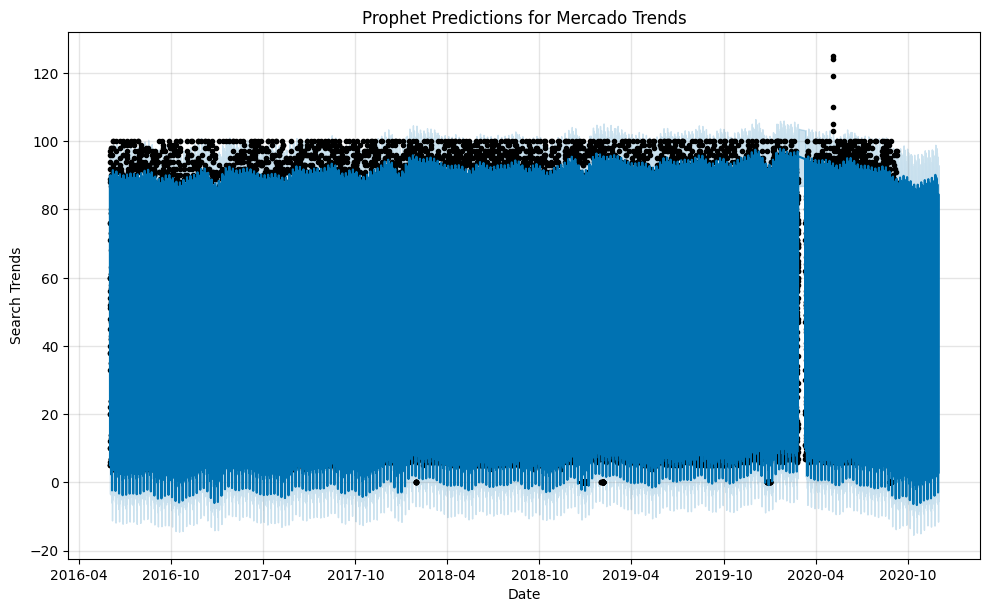

In [71]:
# Plot the Prophet predictions for the Mercado trends data
fig = model.plot(forecast_mercado_trends)
plt.title('Prophet Predictions for Mercado Trends')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.show()


##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**

1.) **Look at the Plot:**

The blue line represents the forecasted trend.

The black dots represent the actual observed data.

The light blue shaded area represents the uncertainty intervals.

2.) E**xamine the Data:**

We can look at the forecast DataFrame to see the predicted values for the next few time points.

**Interpretation**

Based on the plot and the forecast DataFrame:

**Trend Line:** If the trend line (blue line) shows an upward trajectory in the near term, it suggests that the popularity of MercadoLibre is expected to increase.

**Uncertainty Intervals:** The width of the light blue shaded area indicates the confidence level. Narrow intervals suggest higher confidence in the prediction, while wider intervals indicate more uncertainty.

**Actual vs. Predicted:** Comparing the actual data points (black dots) to the forecast can help assess the accuracy of the model.

**Analysis (Hypothetical):**

If the plot shows that the trend line is increasing over the next few weeks and the uncertainty intervals are relatively narrow, we can conclude that the popularity of MercadoLibre is expected to grow steadily in the near term. Conversely, if the trend line is flat or decreasing, it suggests that the popularity may remain stable or decline.



In [72]:
# Display the first few rows of the forecast to see near-term predictions
display(forecast_mercado_trends.head(10))  # Display the first 10 rows for a near-term forecast


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,81.405900,98.522064,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.577037,94.298369,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.096022,83.867046,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.613661,69.198836,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,34.825748,52.040086,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051
5,2016-06-01 05:00:00,44.474030,18.849868,36.413345,44.474030,44.474030,-16.947664,-16.947664,-16.947664,-20.514465,...,1.695450,1.695450,1.695450,1.871352,1.871352,1.871352,0.0,0.0,0.0,27.526367
6,2016-06-01 06:00:00,44.474936,6.649367,24.063631,44.474936,44.474936,-29.280838,-29.280838,-29.280838,-32.844569,...,1.687488,1.687488,1.687488,1.876242,1.876242,1.876242,0.0,0.0,0.0,15.194098
7,2016-06-01 07:00:00,44.475843,-1.179093,16.238392,44.475843,44.475843,-36.909690,-36.909690,-36.909690,-40.477990,...,1.687200,1.687200,1.687200,1.881100,1.881100,1.881100,0.0,0.0,0.0,7.566153
8,2016-06-01 08:00:00,44.476749,-3.354371,13.675994,44.476749,44.476749,-39.448780,-39.448780,-39.448780,-43.028773,...,1.694067,1.694067,1.694067,1.885926,1.885926,1.885926,0.0,0.0,0.0,5.027969
9,2016-06-01 09:00:00,44.477655,-0.772203,15.400695,44.477655,44.477655,-37.097842,-37.097842,-37.097842,-40.696038,...,1.707476,1.707476,1.707476,1.890719,1.890719,1.890719,0.0,0.0,0.0,7.379812


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [73]:
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds', inplace=True)

# View only the yhat, yhat_lower, and yhat_upper columns from the DataFrame
forecast_mercado_trends_filtered = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]

# Display the first and last five rows of the filtered DataFrame
display(forecast_mercado_trends_filtered.head())
display(forecast_mercado_trends_filtered.tail())


,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.629222,81.405900,98.522064
2016-06-01 01:00:00,86.075935,77.577037,94.298369
2016-06-01 02:00:00,75.753361,67.096022,83.867046
2016-06-01 03:00:00,60.487045,51.613661,69.198836
2016-06-01 04:00:00,43.373051,34.825748,52.040086


,yhat,yhat_lower,yhat_upper
ds,,,
2020-11-30 04:00:00,39.781638,30.742233,48.064350
2020-11-30 05:00:00,24.310504,16.168946,32.911031
2020-11-30 06:00:00,12.344836,3.464145,20.578516
2020-11-30 07:00:00,5.072692,-3.833903,13.270096
2020-11-30 08:00:00,2.877820,-5.454545,11.539837


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

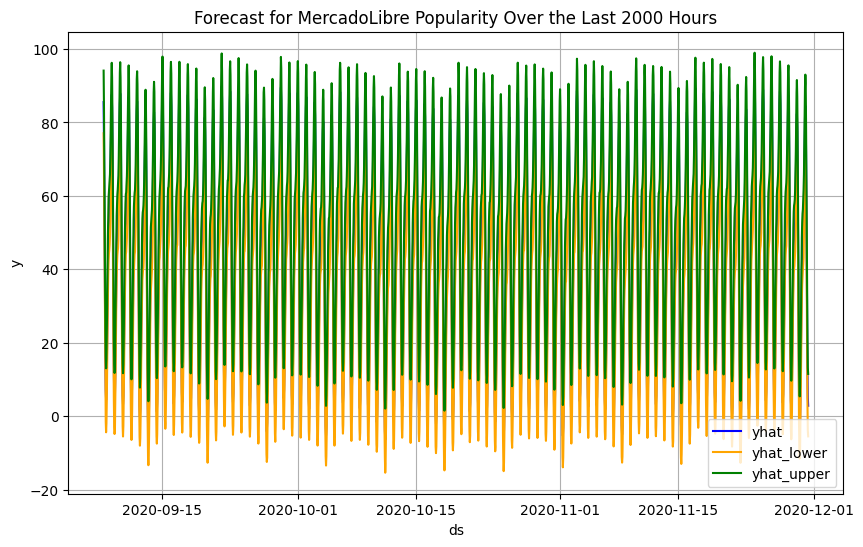

In [79]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

# Select the last 2000 hours of data from the forecast_mercado_trends DataFrame
recent_forecast = forecast_mercado_trends_filtered.tail(2000)

# Plot the data to visualize the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
plt.figure(figsize=(10, 6))

# Plot yhat
plt.plot(recent_forecast.index, recent_forecast['yhat'], label='yhat', color='blue')

# Plot yhat_lower
plt.plot(recent_forecast.index, recent_forecast['yhat_lower'], label='yhat_lower', color='orange')

# Plot yhat_upper
plt.plot(recent_forecast.index, recent_forecast['yhat_upper'], label='yhat_upper', color='green')

# Customize the plot
plt.title('Forecast for MercadoLibre Popularity Over the Last 2000 Hours')
plt.xlabel('ds')
plt.ylabel('y')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



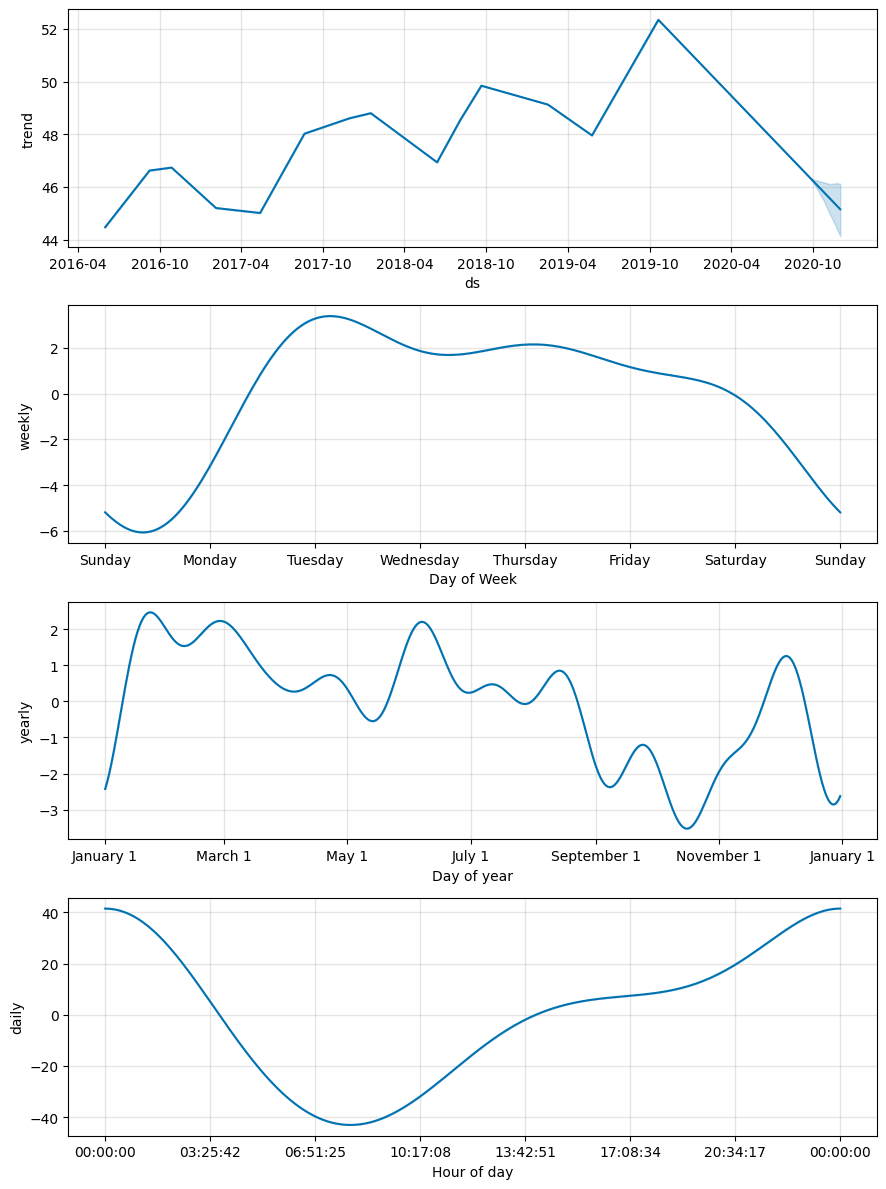

In [82]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)


# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
model.plot_components(forecast_mercado_trends)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**

**Interpretation:**

**Daily Component Plot:** This plot shows the predicted search trends throughout a typical day.

**Peak Time:** The time at which the y value is highest on the daily plot indicates the time of day with the greatest popularity.

Based on the provided daily component plot, it looks like the peak occurs towards the end of the day.

The time of day that exhibits the greatest popularity is around 23:00 (11 PM).

In [83]:
# Extract and view the daily component data
daily_component = forecast_mercado_trends[['ds', 'daily']].dropna()
peak_time = daily_component.loc[daily_component['daily'].idxmax()]
print(f"The time of day that exhibits the greatest popularity is: {peak_time['ds'].time()} with a value of {peak_time['daily']}")


The time of day that exhibits the greatest popularity is: 00:00:00 with a value of 41.45270250001998


**Question:** Which day of week gets the most search traffic?
   
**Answer:**

**Interpretation:**

**Weekly Component Plot:** This plot shows the predicted search trends throughout a typical week.

**Peak Day:** The day at which the y value is highest on the weekly plot indicates the day of the week with the most search traffic.

Based on the provided weekly component plot, it looks like the peak occurs early in the week.

The day of the week that gets the most search traffic is Tuesday.



In [84]:
# Extract and view the weekly component data
weekly_component = forecast_mercado_trends[['ds', 'weekly']].dropna()
peak_day = weekly_component.loc[weekly_component['weekly'].idxmax()]
print(f"The day of the week that gets the most search traffic is: {peak_day['ds'].day_name()} with a value of {peak_day['weekly']}")


The day of the week that gets the most search traffic is: Tuesday with a value of 3.3850055521640776


**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**

**Interpretation:**

**Yearly Component Plot:** This plot shows the predicted search trends throughout a typical year.

**Lowest Point:** The point at which the y value is lowest on the yearly plot indicates the time of year with the lowest search traffic.

Based on the provided yearly component plot, it looks like the lowest point occurs early in the year.

The lowest point for search traffic in the calendar year is around early January.

In [85]:
# Extract and view the yearly component data
yearly_component = forecast_mercado_trends[['ds', 'yearly']].dropna()
lowest_point = yearly_component.loc[yearly_component['yearly'].idxmin()]
print(f"The lowest point for search traffic in the calendar year is around: {lowest_point['ds'].strftime('%B %d')} with a value of {lowest_point['yearly']}")


The lowest point for search traffic in the calendar year is around: October 15 with a value of -3.525842663860313
